In [17]:
#!pip install riroriro

In [18]:
import numpy as np
import pandas as pd

# GW Simulations
import riroriro.inspiralfuns as ins
import riroriro.mergerfirstfuns as me1
import riroriro.matchingfuns as mat
import riroriro.mergersecondfuns as me2

# Manipulating audio signals
import librosa
import librosa.display
import math
import matplotlib.pyplot as plt

In [4]:
# Parameters:
# logMC: system mass (0.0-2.0)
# q: mass ratio (0.1-1.0)
# D: distance (Mpc)
# merger_type: 'BH'=binary black hole merger, 'NS'=binary neutron star merger
# flow: low frequency (Hz) 
def gen_gw(logMc=1.4, q=0.8, D=100.0, flow=10.0, merger_type='BH'):
    
    '''
    Generate gravitational waves
    
    '''
    
    M, eta = ins.get_M_and_eta(logMc=logMc,q=q)
    start_x = ins.startx(M,flow)
    end_x = ins.endx(eta,merger_type)
    x, xtimes, dt = ins.PN_parameter_integration(start_x,end_x,M,eta)
    realtimes = ins.inspiral_time_conversion(xtimes,M)
    i_phase, omega, freq = ins.inspiral_phase_freq_integration(x,dt,M)
    r, rdot = ins.radius_calculation(x,M,eta)
    A1, A2 = ins.a1_a2_calculation(r,rdot,omega,D,M,eta)
    i_Aorth, i_Adiag = ins.inspiral_strain_polarisations(A1,A2,i_phase)
    i_amp = ins.inspiral_strain_amplitude(i_Aorth,i_Adiag)
    i_time = realtimes
    i_omega = omega
    sfin, wqnm = me1.quasi_normal_modes(eta)
    alpha, b, C, kappa = me1.gIRS_coefficients(eta,sfin)
    fhat, m_omega = me1.merger_freq_calculation(wqnm,b,C,kappa)
    fhatdot = me1.fhat_differentiation(fhat)
    m_time = me1.merger_time_conversion(M)
    min_switch_ind = mat.min_switch_ind_finder(i_time,i_omega,m_time,m_omega)
    final_i_index = mat.final_i_index_finder(min_switch_ind,i_omega,m_omega)
    time_offset = mat.time_offset_finder(min_switch_ind,final_i_index,i_time,m_time)
    i_m_time, i_m_omega = mat.time_frequency_stitching(min_switch_ind,final_i_index,time_offset,i_time,i_omega,m_time,m_omega)
    i_m_freq = mat.frequency_SI_units(i_m_omega,M)
    m_phase = me2.merger_phase_calculation(min_switch_ind,final_i_index,i_phase,m_omega)
    i_m_phase = me2.phase_stitching(final_i_index,i_phase,m_phase)
    m_amp = me2.merger_strain_amplitude(min_switch_ind,final_i_index,alpha,i_amp,m_omega,fhat,fhatdot)
    i_m_amp = me2.amplitude_stitching(final_i_index,i_amp,m_amp)
    m_Aorth, m_Adiag = me2.merger_polarisations(final_i_index,m_amp,m_phase,i_Aorth)
    i_m_Aorth, i_m_Adiag = me2.polarisation_stitching(final_i_index,i_Aorth,i_Adiag,m_Aorth,m_Adiag)
    
    return np.array(i_m_time), np.array(i_m_Aorth), np.array(i_m_Adiag), np.array(i_m_freq)b

In [19]:
pd.*date*?

pd.bdate_range
pd.date_range
pd.to_datetime

In [5]:
### Needs to resample the generate signals at regular intervals

SR = 2048 # target sample rate (Hz)
# Parameters:
# dt: time series
# amp: amplitude signal
# seg: output sequence length (seconds)
def resample(dt, amp, seg=2.0):
    end = dt[-1]
    start = end - seg
    d = np.zeros(int(SR*seg))
    for i in range((int(SR*seg))):
        t = start + i/SR
        d[i] = amp[np.where(dt == dt[np.abs(dt-t).argmin()])[0][0]]
    return d

In [6]:

### Plotting utility function

def plot_sig(dt, sig1, sig2=None, seg=2.0):
    end = dt[-1]
    start = end - seg
    plt.figure(1)
    plt.plot(dt, sig1)
    peak = np.max(np.abs(sig1))
    plt.axis([start,end,np.min(sig1)-peak/10,np.max(sig1)+peak/10])
    if sig2 is not None:
        plt.plot(dt, sig2)
    plt.xlabel('Time (s)')
    plt.ylabel('Strain amplitude')

## Testing and Plotting the Signal Generation

In [7]:
m_time, m_Aorth, m_Adiag, m_freq = gen_gw(logMc=1.4, q=0.2)

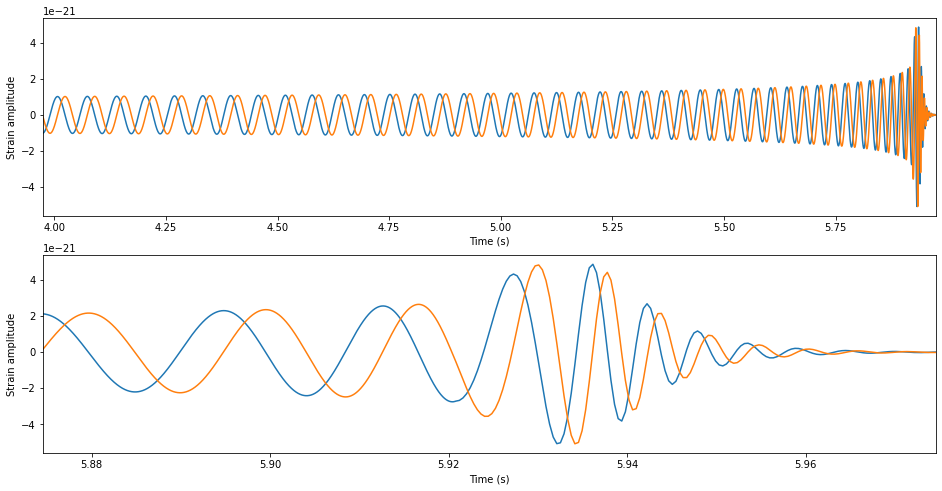

In [14]:
fig = plt.figure(figsize=(16,8))
plt.subplot(2, 1, 1)
plot_sig(m_time, m_Aorth, m_Adiag, seg=2)
plt.subplot(2, 1, 2)
plot_sig(m_time, m_Aorth, m_Adiag, seg=.1)

In [15]:
d1 = resample(m_time, m_Aorth, 2.0)

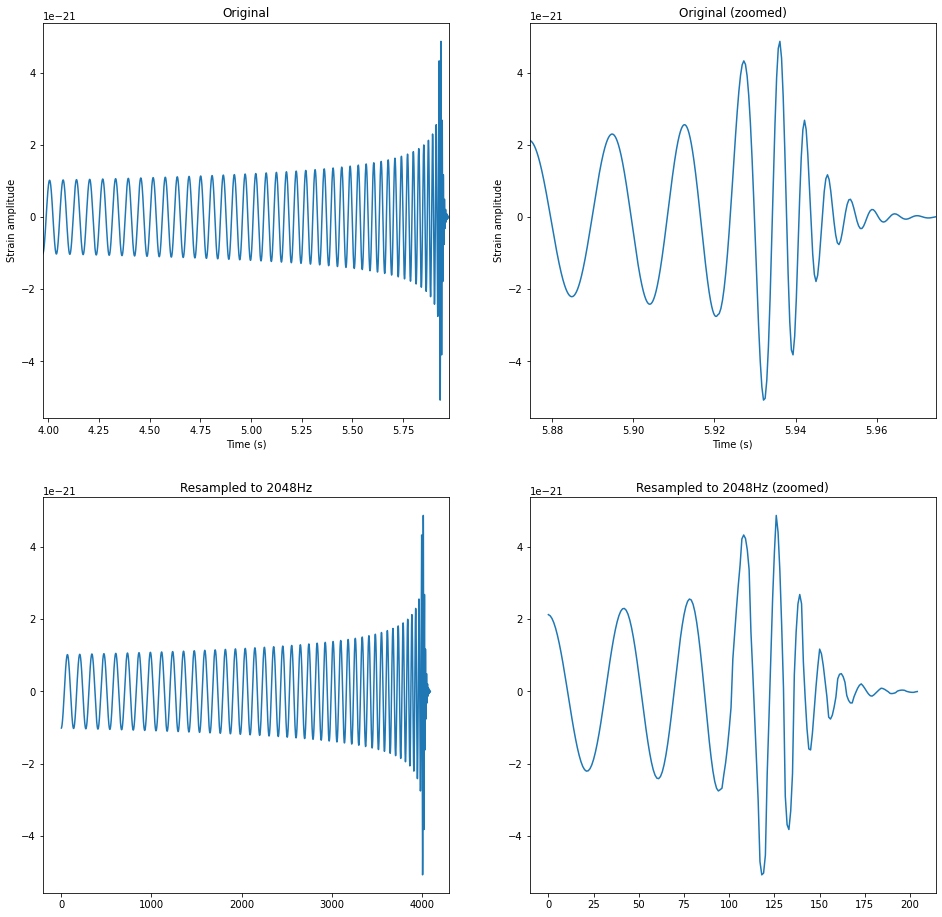

In [16]:
fig = plt.figure(figsize=(16,16))
plt.subplot(2, 2, 1)
plot_sig(m_time, m_Aorth, seg=2)
plt.title('Original')
plt.subplot(2, 2, 2)
plot_sig(m_time, m_Aorth, seg=.1)
plt.title('Original (zoomed)')
plt.subplot(2, 2, 3)
plt.plot(d1)
plt.title('Resampled to 2048Hz')
plt.subplot(2, 2, 4)
plt.plot(d1[-205:])
plt.title('Resampled to 2048Hz (zoomed)');